# オートエンコーダーの訓練

## import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE

## データセットの準備

In [2]:
BATCH_SIZE = 100


# 前処理
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainval_data = MNIST("./data", train=True, download=True, transform=transform)

train_size = int(len(trainval_data) * 0.8)
val_size = int(len(trainval_data) * 0.2)
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

print("train data size: ",len(train_data))   
print("train iteration number: ",len(train_data)//BATCH_SIZE)   
print("val data size: ",len(val_data))   
print("val iteration number: ",len(val_data)//BATCH_SIZE)   


train data size:  48000
train iteration number:  480
val data size:  12000
val iteration number:  120


## モデルの実装

In [3]:
class Encoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    # self.flatten = nn.Flatten()
    self.lr = nn.Linear(28*28, 300)
    self.lr2 = nn.Linear(300, 100)
    self.lr_ave = nn.Linear(100, z_dim)   #average
    self.lr_dev = nn.Linear(100, z_dim)   #log(sigma^2)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    # x = self.flatten(x)
    x = self.lr(x)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    ave = self.lr_ave(x)    #average
    log_dev = self.lr_dev(x)    #log(sigma^2)

    ep = torch.randn_like(ave)   #平均0分散1の正規分布に従い生成されるz_dim次元の乱数
    z = ave + torch.exp(log_dev / 2) * ep   #再パラメータ化トリック
    return z, ave, log_dev

class Decoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)
    self.lr2 = nn.Linear(100, 300)
    self.lr3 = nn.Linear(300, 28*28)
    self.relu = nn.ReLU()
  
  def forward(self, z):
    x = self.lr(z)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    x = torch.sigmoid(x)   #MNISTのピクセル値の分布はベルヌーイ分布に近いと考えられるので、シグモイド関数を適用します。
    return x

class VAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = Encoder(z_dim)
    self.decoder = Decoder(z_dim)
  
  def forward(self, x):
    z, ave, log_dev = self.encoder(x)
    x = self.decoder(z)
    return x, z, ave, log_dev


## 損失関数

In [4]:
def criterion(predict, target, ave, log_dev):
  bce_loss = F.binary_cross_entropy(predict, target, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  loss = bce_loss + kl_loss
  return loss

## 訓練

In [5]:
z_dim = 100
num_epochs = 100
lr = 0.0001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1)

history = {"train_loss": [], "val_loss": [], "ave": [], "log_dev": [], "z": [], "labels":[]}

for epoch in range(num_epochs):
    model.train()
    for i, (x, labels) in enumerate(train_loader):
        input = x.to(device).view(-1, 28*28).to(torch.float32)
        output, z, ave, log_dev = model(input)

        history["ave"].append(ave)
        history["log_dev"].append(log_dev)
        history["z"].append(z)
        history["labels"].append(labels)
        loss = criterion(output, input, ave, log_dev)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
          print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}')
        history["train_loss"].append(loss)

    model.eval()
    with torch.no_grad():
        for i, (x, labels) in enumerate(val_loader):
            input = x.to(device).view(-1, 28*28).to(torch.float32)
            output, z, ave, log_dev = model(input)
            loss = criterion(output, input, ave, log_dev)
            history["val_loss"].append(loss)

        print(f'Epoch: {epoch+1}, val_loss: {loss: 0.4f}')

scheduler.step()


Epoch: 1, loss: -39673.5859
Epoch: 1, loss: -1816185.1250
Epoch: 1, loss: -1891667.8750
Epoch: 1, loss: -1808557.7500
Epoch: 1, loss: -1914479.6250
Epoch: 1, loss: -1965979.7500
Epoch: 1, loss: -1950694.8750
Epoch: 1, loss: -1959245.2500
Epoch: 1, loss: -2150748.0000
Epoch: 1, val_loss: -2116133.7500
Epoch: 2, loss: -2225294.5000
Epoch: 2, loss: -2401929.5000
Epoch: 2, loss: -2431314.2500
Epoch: 2, loss: -2774114.7500
Epoch: 2, loss: -2717682.2500
Epoch: 2, loss: -2610350.2500
Epoch: 2, loss: -2910336.7500
Epoch: 2, loss: -2911521.5000
Epoch: 2, loss: -3345902.5000
Epoch: 2, val_loss: -3388214.7500
Epoch: 3, loss: -3571014.5000
Epoch: 3, loss: -3693374.0000
Epoch: 3, loss: -4044944.0000
Epoch: 3, loss: -3832649.5000
Epoch: 3, loss: -3921844.2500
Epoch: 3, loss: -3908493.5000
Epoch: 3, loss: -4544018.0000
Epoch: 3, loss: -4222214.5000
Epoch: 3, loss: -4396874.5000
Epoch: 3, val_loss: -4615603.0000
Epoch: 4, loss: -4551966.0000
Epoch: 4, loss: -4471686.5000
Epoch: 4, loss: -4507530.0000


## 訓練における損失の推移

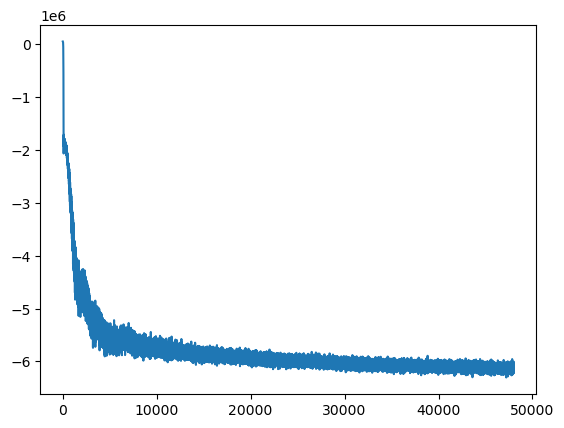

In [6]:
train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)

## 検証データに対する損失の推移

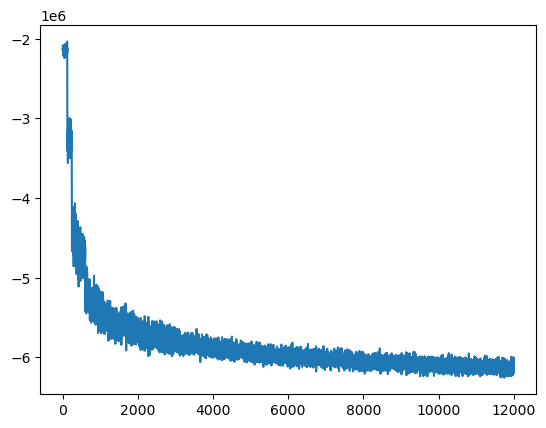

In [7]:
val_loss_tensor = torch.stack(history["val_loss"])
val_loss_np = val_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(val_loss_np)

# テスト

## テストデータの準備

In [8]:
test_data = MNIST("./data", train=False, download=True, transform=transform)

test_loader = DataLoader(dataset=test_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

print("test data size: ",len(test_data))   
print("test iteration number: ",len(test_data)//BATCH_SIZE)

test data size:  10000
test iteration number:  100


## 特徴量zを取得

In [9]:
nn_outputs = []
true_labels = []

model.eval()
with torch.no_grad():
    for i, (x, labels) in enumerate(val_loader):
        input = x.to(device).view(-1, 28*28).to(torch.float32)
        output, z, ave, log_dev = model(input)

        nn_outputs.extend(z.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

nn_outputs = np.array(nn_outputs)
true_labels = np.array(true_labels)

# k-meansクラスタリング

In [10]:
kmeans = KMeans(n_clusters=10, random_state=0)  # クラスターの数はあなたのタスクによります
kmeans.fit(nn_outputs)

/Users/shintaro/anaconda3/envs/patern_recognition/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=0)

## ハンガリアンアルゴリズム

In [11]:
# confusion matrixを計算
cm = confusion_matrix(true_labels, kmeans.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)

# 最適な対応を用いて予測ラベルを修正
new_labels = np.zeros_like(kmeans.labels_)
for row, col in zip(rows, cols):
    new_labels[kmeans.labels_ == col] = row

In [12]:
accuracy = accuracy_score(true_labels, new_labels)
print(f'Accuracy: {accuracy * 100}%')

Accuracy: 56.708333333333336%


## 可視化

In [13]:
# tsneによる可視化
tsne = TSNE(n_components=2, random_state=0)
nn_outputs = tsne.fit_transform(nn_outputs)

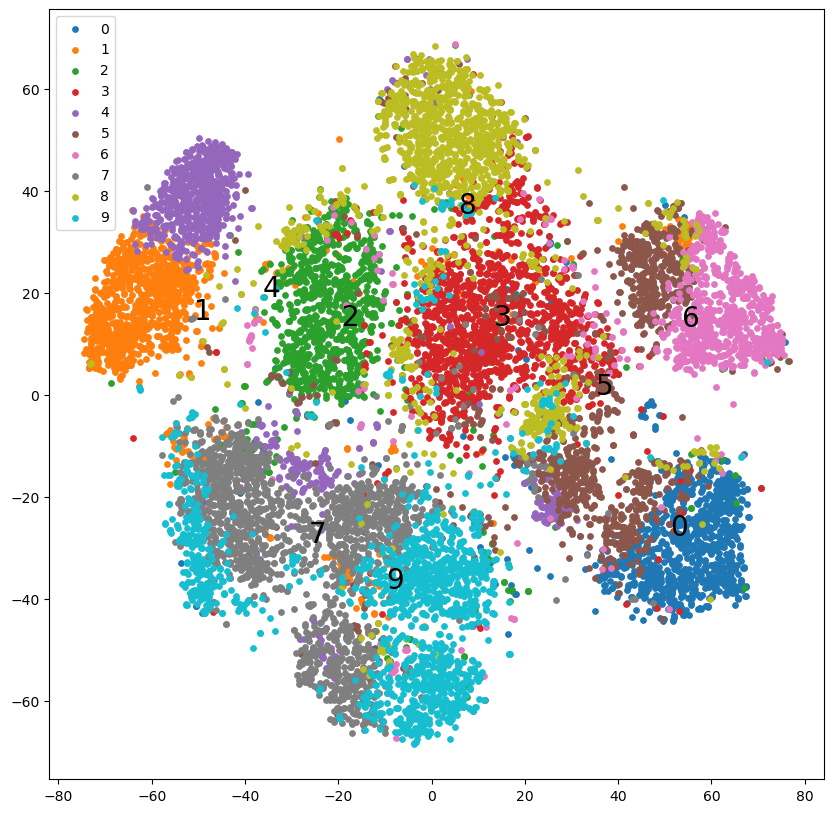

In [14]:
nn_outputs = np.array(nn_outputs)
plt.figure(figsize=[10,10])

cmap_keyword = "tab10"
cmap = plt.get_cmap(cmap_keyword)

for label in range(10):
    x = nn_outputs[:,0][new_labels == label]
    y = nn_outputs[:,1][new_labels == label]
    plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
    plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")

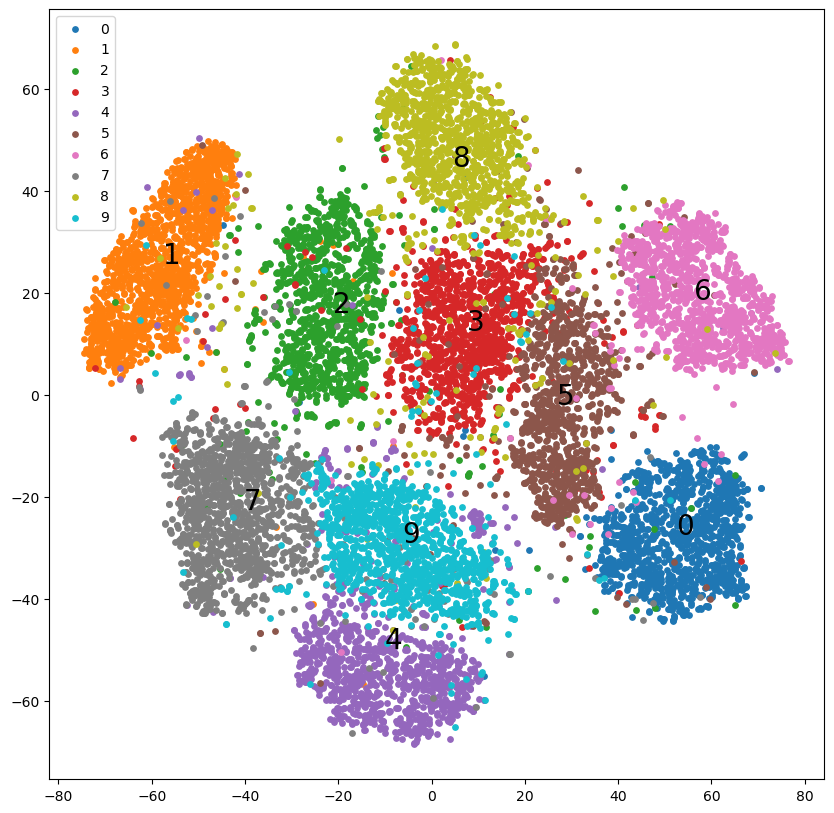

In [15]:
true_labels = np.array(true_labels)
plt.figure(figsize=[10,10])
for label in range(10):
    x = nn_outputs[:,0][true_labels == label]
    y = nn_outputs[:,1][true_labels == label]
    plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
    plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")

# GMMクラスタリング

In [16]:
gmm = GaussianMixture(n_components=10, random_state=0)
gmm.fit(nn_outputs)

GaussianMixture(n_components=10, random_state=0)

## ハンガリアンアルゴリズム

In [17]:
gmm_labels = gmm.predict(nn_outputs)
# confusion matrixを計算
cm = confusion_matrix(true_labels, gmm_labels)
rows, cols = linear_sum_assignment(cm, maximize=True)

# 最適な対応を用いて予測ラベルを修正
new_labels = np.zeros_like(gmm_labels)
for row, col in zip(rows, cols):
    new_labels[gmm_labels == col] = row

In [18]:
accuracy = accuracy_score(true_labels, new_labels)
print(f'Accuracy: {accuracy * 100}%')

Accuracy: 90.39166666666667%


## 可視化

In [19]:
# tsneによる多次元の可視化
# tsne = TSNE(n_components=2, random_state=0)
# nn_outputs = tsne.fit_transform(nn_outputs)

### クラスタリング結果

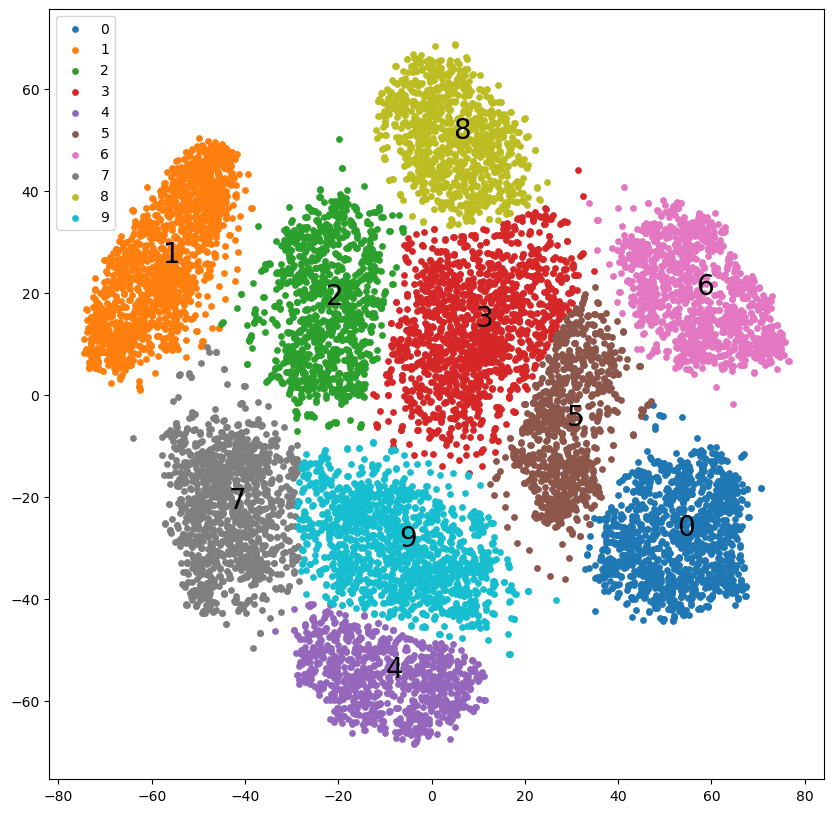

In [22]:
nn_outputs = np.array(nn_outputs)
plt.figure(figsize=[10,10])

cmap_keyword = "tab10"
cmap = plt.get_cmap(cmap_keyword)

for label in range(10):
    x = nn_outputs[:,0][new_labels == label]
    y = nn_outputs[:,1][new_labels == label]
    plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
    plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")
plt.savefig('result.png')

### 正解ラベル

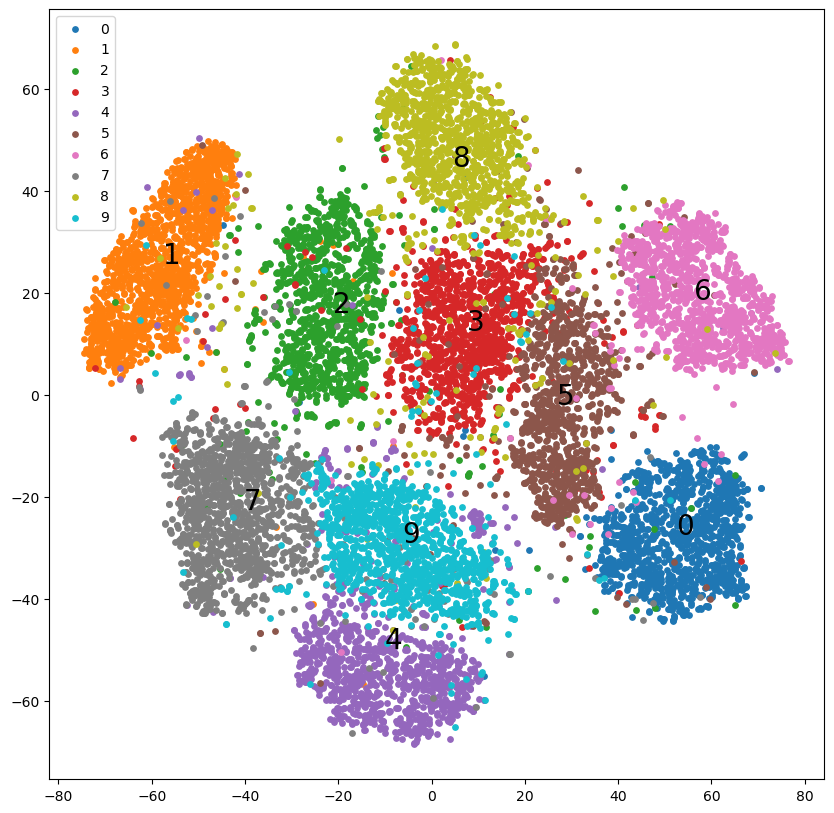

In [23]:
true_labels = np.array(true_labels)
plt.figure(figsize=[10,10])
for label in range(10):
    x = nn_outputs[:,0][true_labels == label]
    y = nn_outputs[:,1][true_labels == label]
    plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
    plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")
plt.savefig('grand-truth.png')